In [104]:
import pandas as pd
import numpy as np
import plotly.express as px


### Data preprocessing

In [105]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('../data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [106]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 864


In [107]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [108]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
#metadata.head()

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


In [109]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status_base'] = metadata['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')


(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


In [110]:
px.box(metadata, x = 'event.PAM50', y = 'HRD-sum', color = 'HRD_status_base')

### Applying soft labels to HRD-sum

In [124]:
# Soft label method
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh)) - 0.5) ** 2) + 0.5
    if median <= x < HRD_thresh:
        return adjustment
    elif HRP_thresh <= x < median:
        return 1 - adjustment
    else:
        #print(f"x: {x} \n median:{median} \n HRD_thresh:{HRD_thresh} \n HRP_thresh: {HRP_thresh}")
        return -1


### Soft labels using total median

In [125]:
metadata_tot = metadata.copy()
total_median = metadata_tot['HRD-sum'].median()
metadata_tot['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if total_median <= x <50 else 'HRP ambiguous' if 10 <= x < total_median else 'None' for x in metadata_tot['HRD-sum']]
metadata_tot['soft prob'] = metadata_tot['HRD-sum'].apply(lambda x: softLabel(x, total_median, 50, 10))

# fixing -1 cases that were not handled correctly
metadata_tot[['HRD-sum', 'HRD_status_base', 'HRD_adjust', 'soft prob']]

# Define conditions and choices
conditions = [
    (metadata_tot['soft prob'] == -1) & (metadata_tot['HRD_adjust'] == 'HRP'),
    (metadata_tot['soft prob'] == -1) & (metadata_tot['HRD_adjust'] == 'HRD')
]

choices = [0, 1]

# Update the 'soft prob dist' column
metadata_tot['soft prob'] = np.select(conditions, choices, default=metadata_tot['soft prob'])

In [131]:
px.strip(metadata_tot, y = 'soft prob', hover_data='HRD-sum')

In [133]:
metadata_tot.to_csv('../data/softlabels_tot.csv')

In [126]:
#calculating medians per subtype
metadata_sub = metadata.copy()
medians = metadata_sub.groupby(["event.PAM50"])["HRD-sum"].median().reset_index() 
medians_pivot = medians.set_index('event.PAM50').T
medians_pivot

event.PAM50,Basal,Her2,LumA,LumB
HRD-sum,55.0,35.0,13.0,31.0


In [127]:
# Applying soft labels across each row
for sub in medians_pivot.columns.tolist():
    metadata_sub['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if medians_pivot.loc['HRD-sum',sub] <= x <50 else 'HRP ambiguous' if 10 <= x < medians_pivot.loc['HRD-sum',sub] else 'None' for x in metadata_sub['HRD-sum']]
    metadata_sub['soft prob'] = metadata_sub['HRD-sum'].apply(lambda x: softLabel(x, medians_pivot.loc['HRD-sum',sub], 50, 10))

In [94]:
px.strip(metadata_sub, x = 'event.PAM50', y = 'soft prob', hover_data='HRD-sum')

In [95]:
# fixing -1 cases that were not handled correctly
metadata_sub[['HRD-sum', 'HRD_status_base', 'HRD_adjust', 'soft prob']]

# Define conditions and choices
conditions = [
    (metadata_sub['soft prob'] == -1) & (metadata_sub['HRD_adjust'] == 'HRP'),
    (metadata_sub['soft prob'] == -1) & (metadata_sub['HRD_adjust'] == 'HRD')
]

choices = [0, 1]

# Update the 'soft prob dist' column
metadata_sub['soft prob'] = np.select(conditions, choices, default=metadata_sub['soft prob'])

In [96]:
px.histogram(metadata_sub, x='soft prob', hover_data='HRD-sum', color = 'event.PAM50', barmode = "overlay")

In [97]:
px.scatter(metadata_sub, x = 'HRD-sum', y= 'soft prob')

In [98]:
metadata_sub.shape

(857, 40)

In [99]:
metadata_sub[metadata_sub['HRD_adjust'] == 'None']

,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC,HRD_status_base,HRD_adjust,soft prob
sample,,,,,,,,,,,,,,,,,,,,,


In [100]:
px.box(metadata_sub, x = 'event.PAM50', y = 'HRD-sum', color = 'HRD_adjust')

In [103]:
metadata_sub.to_csv('../data/softlabels_per_Subtype.csv')

## Visualization graphs

In [107]:
px.scatter(df, x = 'HRD-sum', y = 'Confidence')

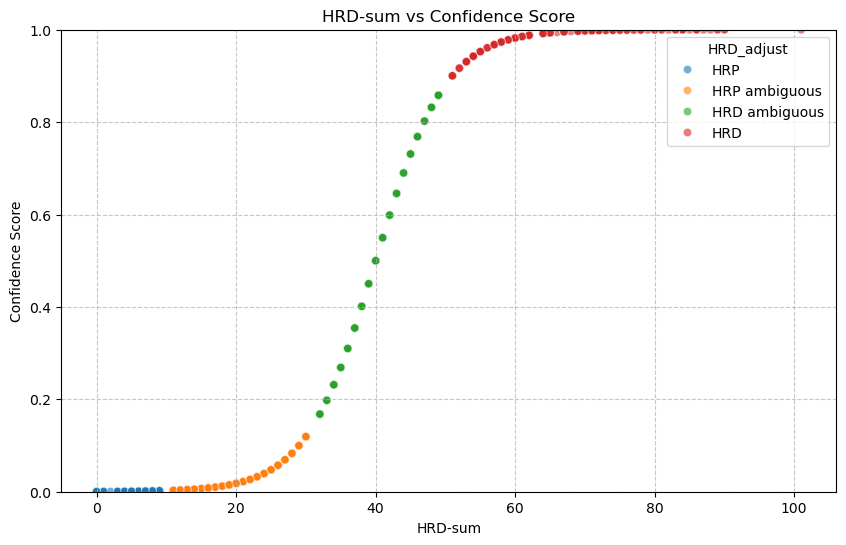

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=df, x='HRD-sum', y='Confidence', hue = 'HRD_adjust', alpha=0.6)

# Add title and labels
plt.title('HRD-sum vs Confidence Score')
plt.xlabel('HRD-sum')
plt.ylabel('Confidence Score')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits for confidence
plt.ylim(0, 1)

plt.show()